This is going to be the similar mass case with circular orbit and then implement Df equation with that


How this Jupyter Notebook will look like:
- Initialize the packets
- initial conditions
- dictate the circular orbit
- forloop
- effective energy plot (coming soon)

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import scipy as sci
from scipy import integrate
from scipy.integrate import odeint
from astropy import units as u
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import astropy.constants as const
import math

In [29]:
plt.rcParams['font.family'] = 'Times New Roman'
#this is to make the font of the plots to be Times New Roman

In [30]:
const.G

<<class 'astropy.constants.codata2018.CODATA2018'> name='Gravitational constant' value=6.6743e-11 uncertainty=1.5e-15 unit='m3 / (kg s2)' reference='CODATA 2018'>

This is the tests that were done in Kris' github:

In [31]:
a_0 = 2.95 
b_0 = 0.596
mstar_tot = 1e11 * u.Msun
r_eff = (a_0*(mstar_tot/(1.e6*u.Msun))**b_0)* u.pc

print(r_eff)

2817.2281287632354 pc


In [32]:
m1 = 4e8 * u.Msun

rb = (m1/mstar_tot)**(1./3.)*r_eff
print("Binary radius is:", rb)
dyn_hard = (((rb/r_eff)**3)*r_eff).to(u.pc)
print(dyn_hard)

Binary radius is: 447.20708952331626 pc
11.268912515052946 pc


This is going to be the initial conditions

In [33]:
plt.rcParams['font.family'] = 'Times New Roman'
# region Code Snippet 1: IC's
G = const.G #change the innate time to years
m_gal = 1e11 * const.M_sun
#Masses
m1=4e8 * const.M_sun #mass of black hole A 
m2=4e8 * const.M_sun #mass of black hole B
# Will be adding the Standard Gravitational Parameter
#r_i has a separation of 430 pc
sep = 430*u.pc
r1_initial=[((sep/2.).value),0,0] * u.pc
r2_initial=[-((sep/2.).value),0,0] * u.pc
#To arrays
r1=np.array(r1_initial,dtype="float64") * u.pc
r2=np.array(r2_initial,dtype="float64") * u.pc

#Semi-major axis 
a = (0.5 * (sep))
print (a)

#COM
r_com=(m1*r1+m2*r2)/(m1+m2)

#orbital veloctiy
orb_v = (np.sqrt(const.G*(m1+m2)/a)).to(u.km/u.s) #added with Kris' source
orb_v = orb_v.value

#V_i
v1_initial=[0,orb_v, 0] *u.km/u.s
v2_inital=[0,-orb_v,0] *u.km/u.s #km/s

#To arrays
v1=np.array(v1_initial,dtype="float64") *u.km/u.s
v2=np.array(v2_inital,dtype="float64") *u.km/u.s
#Find velocity of COM
v_com=(m1*v1+m2*v2)/(m1+m2)

r = np.sqrt((r2[0] - r1[0])** 2 + (r2[1] - r1[1])** 2 + (r2[2] - r1[2])** 2)

# endregion

print(v1, v2)

215.0 pc
[  0.         126.50459714   0.        ] km / s [   0.         -126.50459714    0.        ] km / s


Dynamical Friction and adding them as each component:

In [34]:
# region Code Snippet 2: DF
r1_com = np.linalg.norm(r1 - r_com)
r2_com = np.linalg.norm(r2 - r_com)

# r1_com = np.sqrt(r1_com[0]**2 + r1_com[1]**2 + r1_com[2]**2) #we have to put the magnitude of the distance from each object from the COM
# r2_com = np.sqrt(r2_com[0]**2 + r2_com[1]**2 + r2_com[2]**2)
 # region code : Semi Major Axes
#redacted the a becuase r = a in circular orbits
# rmax1 = np.max(r1 - r_com)
# rmin1 = np.min(r1 - r_com)
# a1 = (rmax1+rmin1)/2

# rmax2 = np.max(r2 - r_com)
# rmin2 = np.min(r2 - r_com)
# a2 = (rmax2+rmin2)/2
# endregion

o = ((10**(2.2969))*(m_gal/ (10**(11) * const.M_sun))**(0.299)) * (u.km/u.s)
# region code : Coulomb Logarithm
x1 = (r1_com * o**(2)) / (G * m1)
x2 = (r2_com * o**(2)) / (G * m2)
ln_A1 = math.log10(x1.to_value(u.dimensionless_unscaled))
ln_A2 = math.log10(x2.to_value(u.dimensionless_unscaled))
print("ln_A1:", ln_A1, x1)
# endregion
# region code : Dynamical Friction

F_D1 = 0.428 * ln_A1 * (G * m1**2 / r1_com**2)
F_D2 = 0.428 * ln_A2 * (G * m2**2 / r2_com**2)

print("F_D1:", F_D1)
print("F_D2:", F_D2)

print("Dynamical Friction Forces:", F_D1, F_D2)


# Relative velocities
v_r1 = v1 - v2 #trying v1 instead of center of mass
v_r2 = v2 - v1

print(v_r1)

# Unit vectors of relative velocities
v_rel_unit1 = v_r1 / np.linalg.norm(v_r1) #maybe unit vector is not the answer but rather just the direction (unit vector includes magnitude)
v_rel_unit2 = v_r2 / np.linalg.norm(v_r2)



# Dynamical friction force vectors (negative to the velocity vector)
F_D1_vector =-1*(F_D1 * v_rel_unit1)
F_D2_vector = -1*(F_D2 * v_rel_unit2)

print(F_D1_vector, F_D2_vector, v1_initial, v2_inital)

# Convert to desired units
F_D1_vector = F_D1_vector.to((u.kg * u.m) / (u.s**2))
F_D2_vector = F_D2_vector.to((u.kg * u.m) / (u.s**2))


# Convert to acceleration
a_D1 = (F_D1_vector / m1).to(u.km / u.s**2)
a_D2 = (F_D2_vector / m2).to(u.km / u.s**2)






ln_A1: 0.6906173797913483 1.5895230663944142e-22 km2 pc / m3
F_D1: 2.6998639478368075e+62 m3 kg / (pc2 s2)
F_D2: 2.6998639478368075e+62 m3 kg / (pc2 s2)
Dynamical Friction Forces: 2.6998639478368075e+62 m3 kg / (pc2 s2) 2.6998639478368075e+62 m3 kg / (pc2 s2)
[  0.         253.00919428   0.        ] km / s
[-0.00000000e+00 -2.69986395e+62 -0.00000000e+00] m3 kg / (pc2 s2) [-0.00000000e+00  2.69986395e+62 -0.00000000e+00] m3 kg / (pc2 s2) [  0.         126.50459714   0.        ] km / s [   0.         -126.50459714    0.        ] km / s


In [35]:
massterm = (m1+m2)/(10**8*u.Msun)
velterm = ((200*u.km/u.s)/o)**2
dynhard_rad = (10*u.pc*massterm*velterm).to(u.pc)
print(dynhard_rad)

81.5361082035837 pc


In [36]:
coulomb_log_ = np.log10((a*o**2/(const.G*m1)).to(''))
print(coulomb_log_)
prefactor = 19./coulomb_log_
aterm = (a/(5.*u.kpc))**2
vterm = o/(200*u.km/u.s)
mterm = (10**8*u.Msun/(m1))
dyntime = (prefactor*aterm*vterm*mterm*u.Gyr).to(u.Myr)
print(dyntime)
print(np.sqrt(2)* o)


0.6906173797913483
12.596880855045313 Myr
280.1657214412427 km / s


did all the checks that would dictate when they become a hard binary

In [37]:
T = 17 * u.Myr #Total time of simulation
N = 500
delta_t = T/ N
print(delta_t.to(u.yr))

time_span=np.linspace(0, T, N) #Work on this with Kris' link

34000.0 yr


In [38]:
c = 0

Period Test

In [39]:
orbital_period = np.sqrt((4 * (np.pi)**2 / (G * (m1)) * (a**3))).to(u.Myr)

print(orbital_period)

14.766364899677814 Myr


orbital period / dyntime

In [40]:
dyntime / orbital_period

<Quantity 0.85307934>

[[ 9.11570375e-16 -3.56434721e-13 -0.00000000e+00]
 [ 1.82186400e-15 -3.56175789e-13 -0.00000000e+00]
 [ 2.72959394e-15 -3.55736734e-13 -0.00000000e+00]
 ...
 [-3.28855582e-14  1.87717650e-13 -0.00000000e+00]
 [-3.30428118e-14  1.85244626e-13 -0.00000000e+00]
 [-3.31960294e-14  1.82812866e-13 -0.00000000e+00]] [[-9.11570375e-16  3.56434721e-13 -0.00000000e+00]
 [-1.82186400e-15  3.56175789e-13 -0.00000000e+00]
 [-2.72959394e-15  3.55736734e-13 -0.00000000e+00]
 ...
 [ 3.28855582e-14 -1.87717650e-13 -0.00000000e+00]
 [ 3.30428118e-14 -1.85244626e-13 -0.00000000e+00]
 [ 3.31960294e-14 -1.82812866e-13 -0.00000000e+00]]


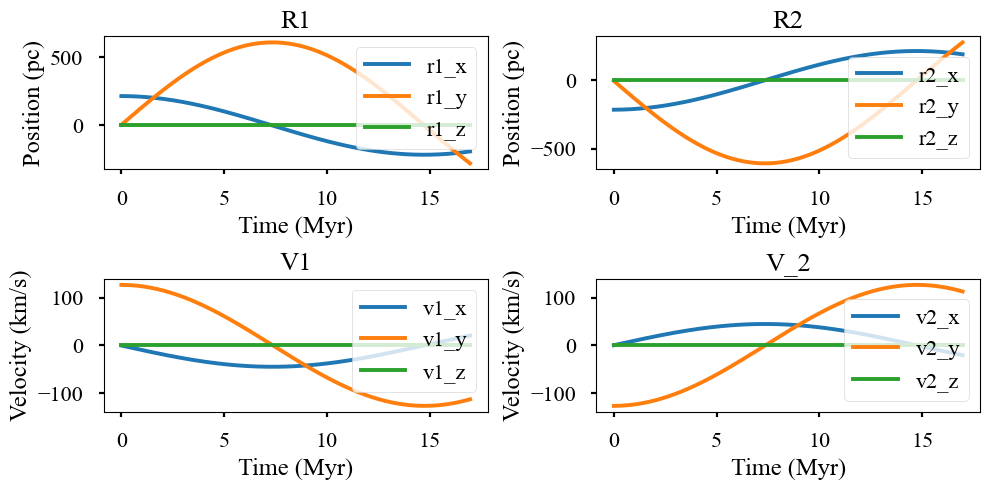

In [41]:
# region code : past for loop
r1_sol = []
r2_sol = []
v1_sol = []
v2_sol = []
F_D1sol = []
F_D2sol = []
F_force1 = []
F_force2 = []



for i in range(N):
    dv1bydt=((G*m2*(r2-r1))/r**3).to(u.km / u.s**2) + (c * a_D1)
    dv2bydt=((-G*m1*(r2-r1))/r**3).to(u.km / u.s**2) + (c * a_D2) 
    v1 += dv1bydt * delta_t
    v2 += dv2bydt * delta_t

    r1 += v1.to(u.pc / u.s) * delta_t
    r2 += v2.to(u.pc / u.s) * delta_t
    # region Code Snippet 2: DF
    r1_com = r1 - r_com
    r2_com = r2 - r_com

    r1_com = np.sqrt(r1_com[0]**2 + r1_com[1]**2 + r1_com[2]**2) #we have to put the magnitude of the distance from each object from the COM
    r2_com = np.sqrt(r2_com[0]**2 + r2_com[1]**2 + r2_com[2]**2)
   
    o = ((10**(2.2969))*(m_gal/ (10**(11) * const.M_sun))**(0.299)) * (u.km/u.s)
    # region code : Coulomb Logarithm
    x1 = (np.abs(r1_com.to(u.km)) * o**(2)) / (G * m1)
    x2 = (np.abs(r2_com.to(u.km)) * o**(2)) / (G * m2)
    ln_A1 = math.log10(x1.to_value(u.dimensionless_unscaled))
    ln_A2 = math.log10(x2.to_value(u.dimensionless_unscaled))
    # endregion


    F_D1 = 0.428 * ln_A1 * (G * m1**2 / r1_com**2)
    F_D2 = 0.428 * ln_A2 * (G * m2**2 / r2_com**2)




    v_r1 = v1 - v_com
    v_r2 = v2 - v_com


    v_rel_unit1 = v_r1 / np.linalg.norm(v_r1)
    v_rel_unit2 = v_r2 / np.linalg.norm(v_r2)

    F_D1_vector = -1 *(F_D1 * v_rel_unit1)
    F_D2_vector = -1 *(F_D2 * v_rel_unit2)


    F_D1_vector = F_D1_vector.to((u.kg * u.m) / (u.s**2))
    F_D2_vector = F_D2_vector.to((u.kg * u.m) / (u.s**2))



    # Convert to acceleration
    a_D1 = (F_D1_vector / m1).to(u.km / u.s**2)
    a_D2 = (F_D2_vector / m2).to(u.km / u.s**2)



    # Append results to lists (if needed)
    F_force1.append(F_D1_vector.to(u.kg * u.m / u.s**2))
    F_force2.append(F_D2_vector.to(u.kg * u.m / u.s**2))
    F_D1sol.append([a_D1[0].value, a_D1[1].value, a_D1[2].value])
    F_D2sol.append([a_D2[0].value, a_D2[1].value, a_D2[2].value])

    r1_sol.append(r1.copy())
    r2_sol.append(r2.copy())
    v1_sol.append(v1.copy())
    v2_sol.append(v2.copy())


time_values = np.arange(0, N) * delta_t.to(u.Myr).value  # Convert delta_t to Myr or desired unit


r1_sol = np.array(r1_sol)  
r2_sol = np.array(r2_sol)  
v1_sol = np.array(v1_sol)  
v2_sol = np.array(v2_sol) 
F_D1sol = np.array(F_D1sol)
F_D2sol = np.array(F_D2sol)
F_force1 = np.array(F_force1)
F_force2 = np.array(F_force2) 
print(F_D1sol, F_D2sol)


# endregion 
# region


fig, axs = plt.subplots(2, 2, figsize=(10, 5))


axs[0, 0].plot(time_values, r1_sol[:, 0], label="r1_x")
axs[0, 0].plot(time_values, r1_sol[:, 1], label="r1_y")
axs[0, 0].plot(time_values, r1_sol[:, 2], label="r1_z")
axs[0, 0].set_title("R1")
axs[0, 0].set_xlabel("Time (Myr)")
axs[0, 0].set_ylabel("Position (pc)")
axs[0, 0].legend()


axs[0, 1].plot(time_values, r2_sol[:, 0], label="r2_x")
axs[0, 1].plot(time_values, r2_sol[:, 1], label="r2_y")
axs[0, 1].plot(time_values, r2_sol[:, 2], label="r2_z")
axs[0, 1].set_title("R2")
axs[0, 1].set_xlabel("Time (Myr)")
axs[0, 1].set_ylabel("Position (pc)")
axs[0, 1].legend()


axs[1, 0].plot(time_values, v1_sol[:, 0], label="v1_x")
axs[1, 0].plot(time_values, v1_sol[:, 1], label="v1_y")
axs[1, 0].plot(time_values, v1_sol[:, 2], label="v1_z")
axs[1, 0].set_title("V1")
axs[1, 0].set_xlabel("Time (Myr)")
axs[1, 0].set_ylabel("Velocity (km/s)")
axs[1, 0].legend()


axs[1, 1].plot(time_values, v2_sol[:, 0], label="v2_x")
axs[1, 1].plot(time_values, v2_sol[:, 1], label="v2_y")
axs[1, 1].plot(time_values, v2_sol[:, 2], label="v2_z")
axs[1, 1].set_title("V_2")
axs[1, 1].set_xlabel("Time (Myr)")
axs[1, 1].set_ylabel("Velocity (km/s)")
axs[1, 1].legend()


plt.tight_layout()
plt.show()

# endregion
    


In [42]:
print(r1_sol)

[[ 214.9887501     4.39884487    0.        ]
 [ 214.96625087    8.79745958    0.        ]
 [ 214.93250351   13.19561396    0.        ]
 ...
 [-192.23353195 -270.38255451    0.        ]
 [-191.53197858 -274.31560329    0.        ]
 [-190.82040328 -278.23429846    0.        ]]


*mag of velocity + separation vector

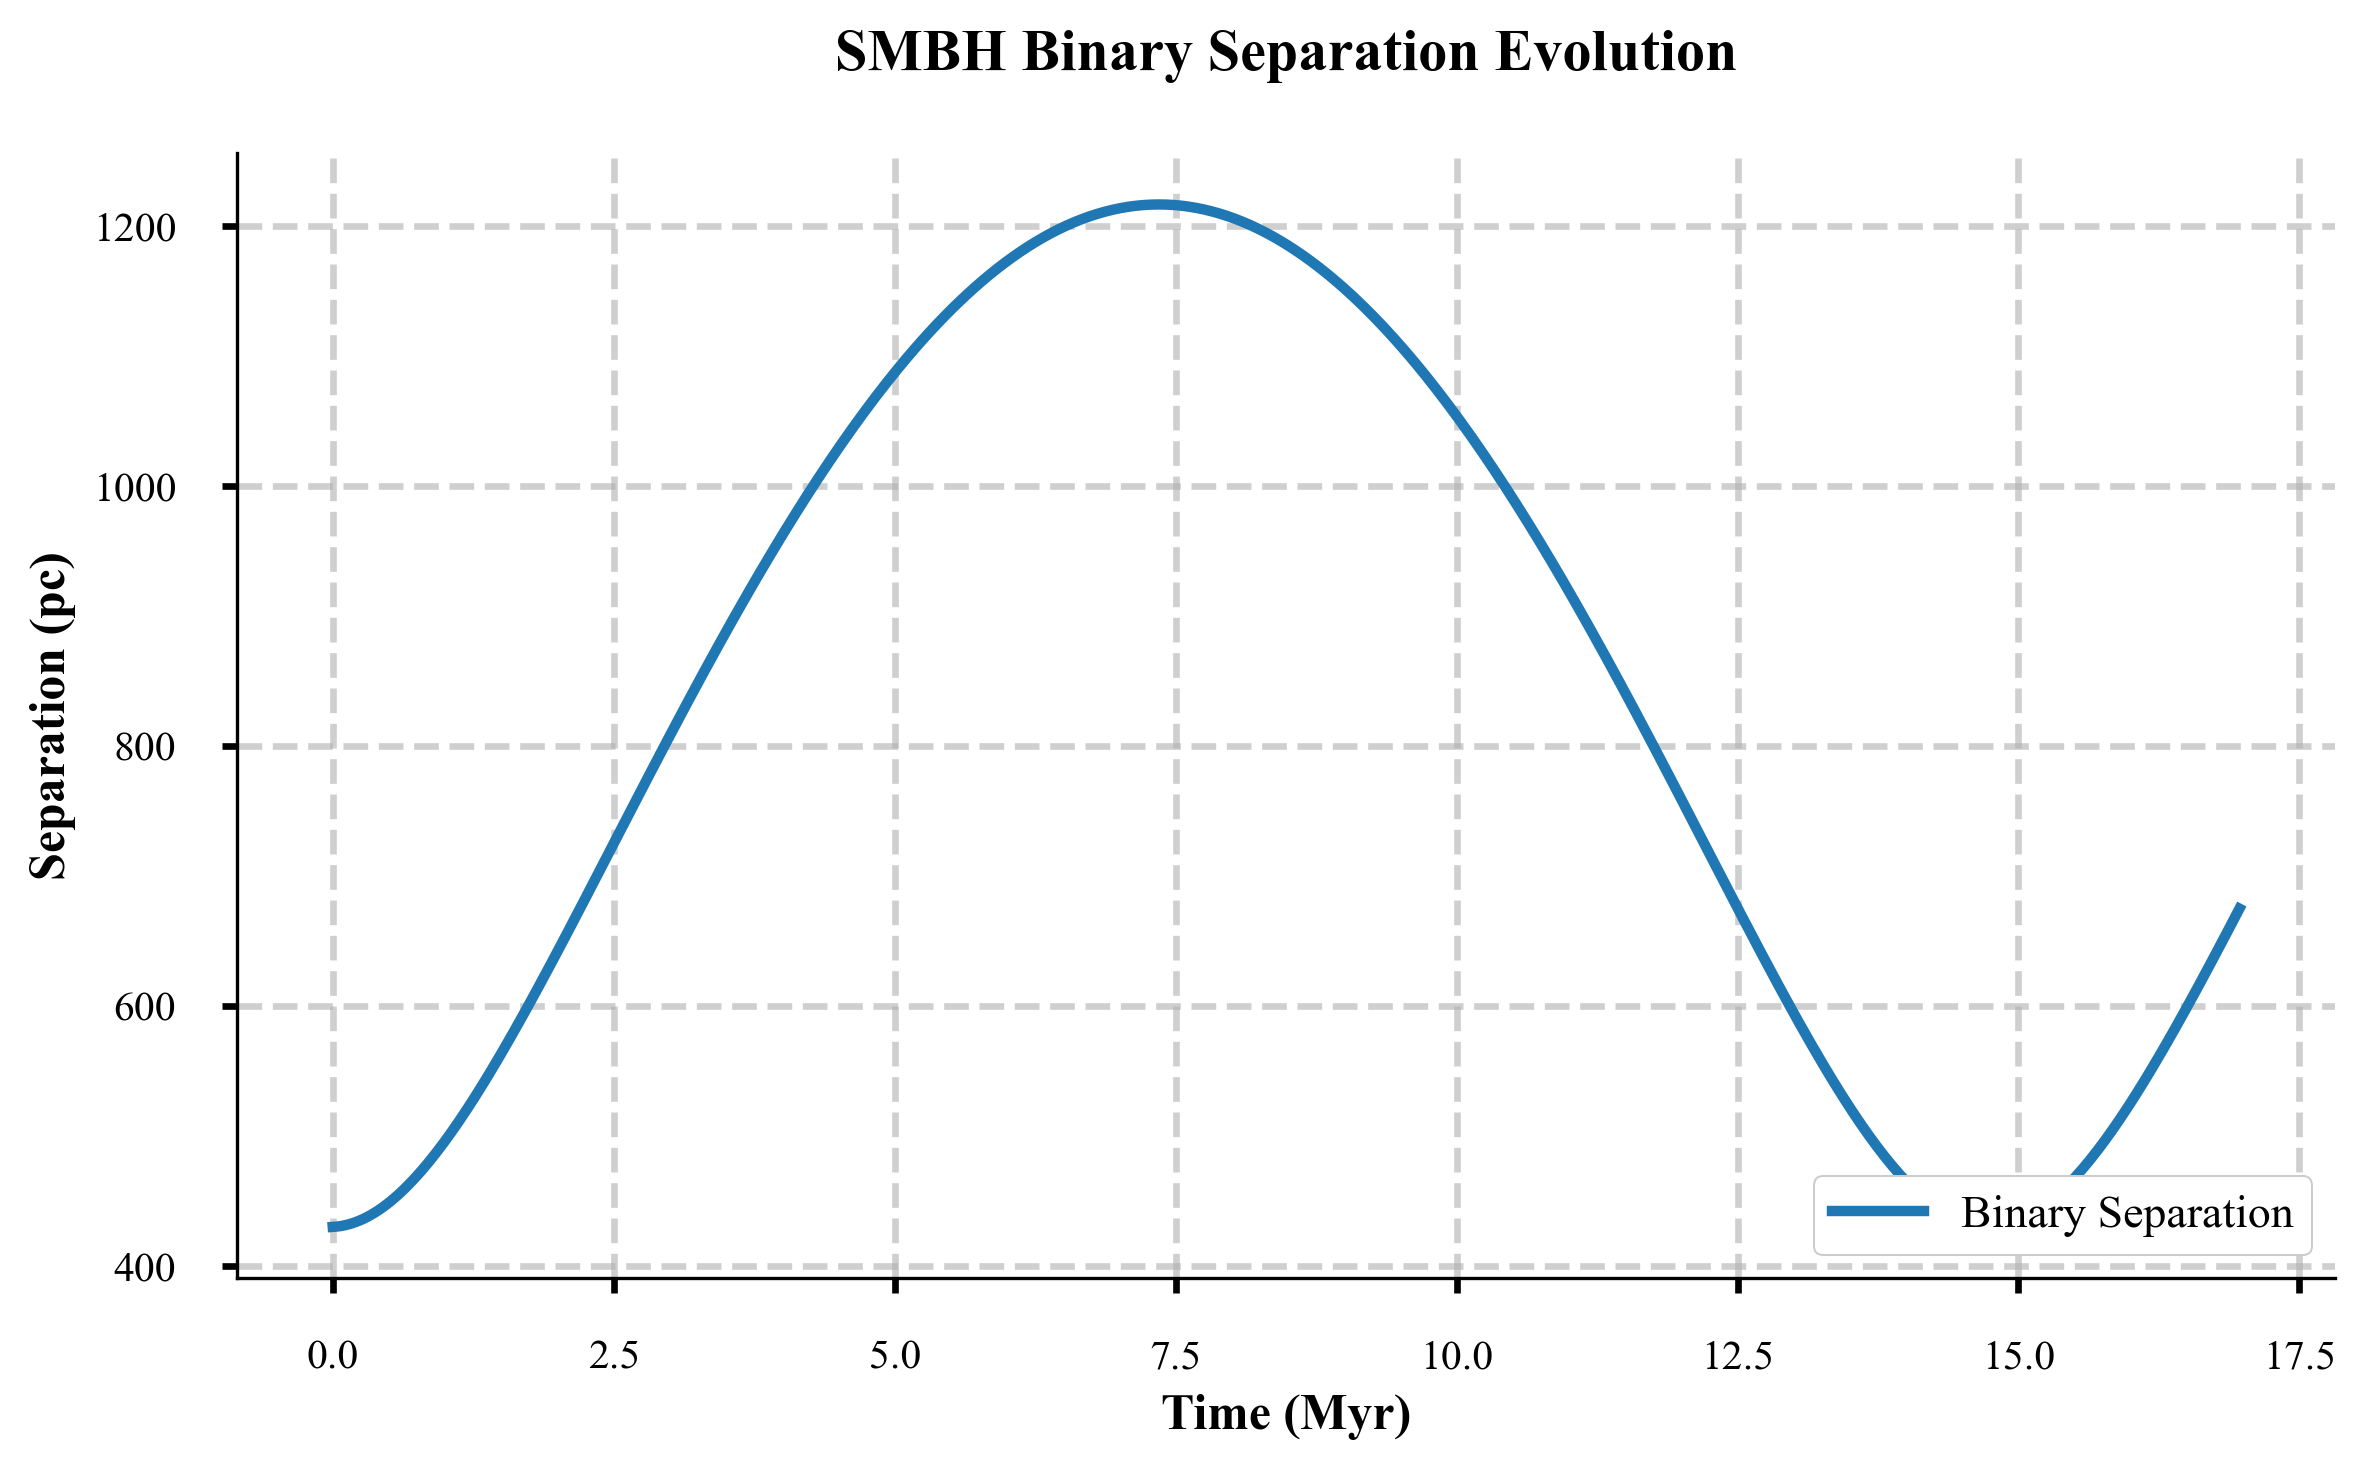

In [43]:
import matplotlib.pyplot as plt
import numpy as np


sep = r1_sol - r2_sol
sep_mag = np.linalg.norm(sep, axis=1)


plt.figure(figsize=(8, 5), dpi=300)  # Higher resolution
plt.style.use('seaborn-v0_8-poster')  # Clean, publication-ready style


plt.plot(time_values, sep_mag, 
         linewidth=2.5,
         color='#1f77b4',  # Professional blue
         label="Binary Separation")


plt.xlabel('Time (Myr)', fontsize=12, fontweight='bold')
plt.ylabel('Separation (pc)', fontsize=12, fontweight='bold')
plt.title('SMBH Binary Separation Evolution', 
          fontsize=14, pad=20, fontweight='bold')


plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)


plt.legend(frameon=True, framealpha=1, 
           facecolor='white', fontsize=11,
           loc='upper right' if sep_mag[-1] < sep_mag[0] else 'lower right')


ax = plt.gca()
ax.spines[['top', 'right']].set_visible(False)




plt.tight_layout()

plt.savefig('smbh_separation.png', bbox_inches='tight', dpi=300)
plt.show()

Mya's Code for compiling all the plots together

/var/folders/rf/799sdl_537nf32dnhw741jq80000gn/T/ipykernel_98577/2009217551.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  a.legend()


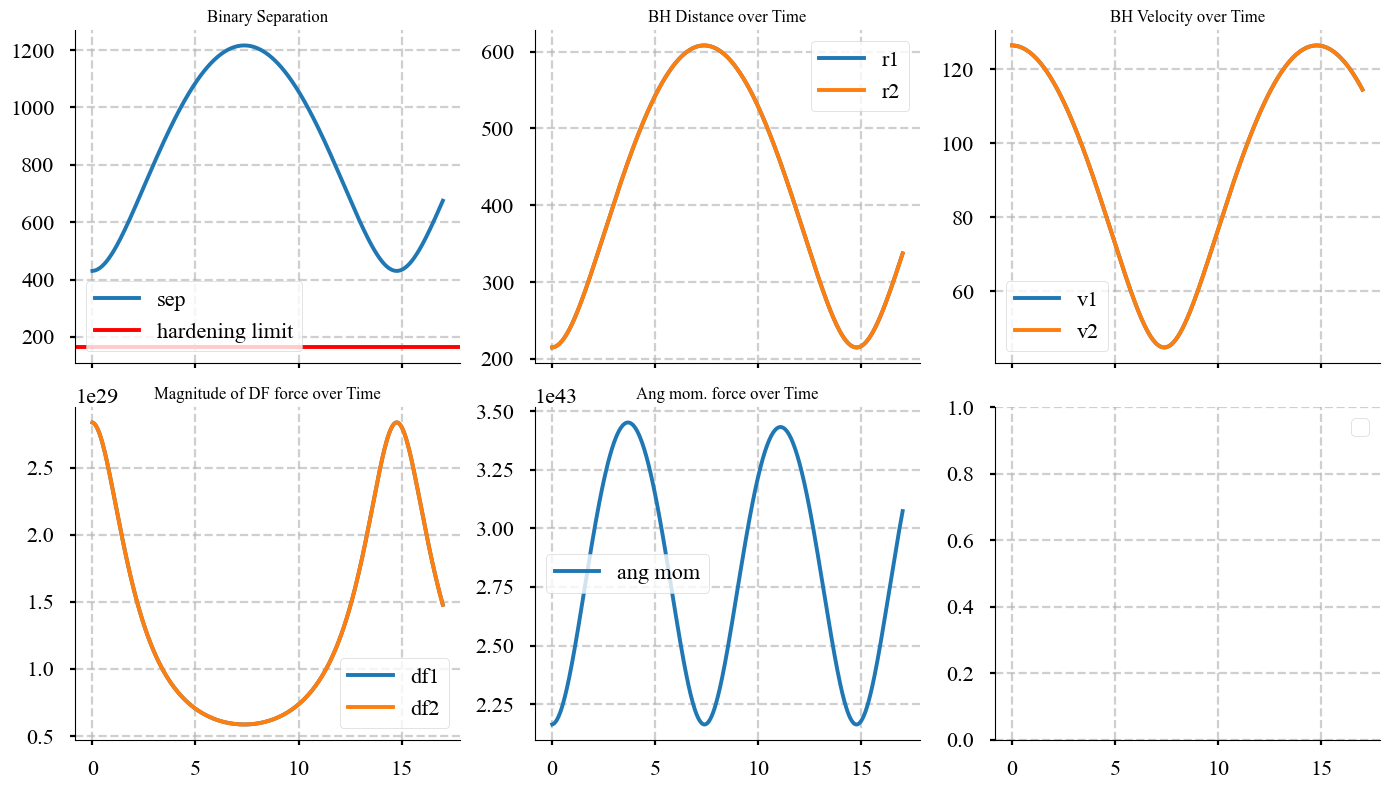

In [44]:
# First row
fig, ax = plt.subplots(2, 3, figsize=(14, 8), sharex=True)
pos_mag = np.linalg.norm(r1_sol, axis=1)
vel_mag = np.linalg.norm(v1_sol, axis=1)
ang_mom = m1 * (pos_mag * vel_mag) 

ax[0, 0].plot(time_span, np.linalg.norm(sep, axis=1), label='sep')
ax[0, 0].set_title('Binary Separation', fontsize = 12)
ax[0, 0].axhline(dynhard_rad.value * 2, color='red', label="hardening limit")

ax[0, 1].plot(time_span, np.linalg.norm(r1_sol, axis=1), label="r1")
ax[0, 1].set_title('BH Distance over Time', fontsize = 12)
ax[0, 1].plot(time_span, np.linalg.norm(r2_sol, axis=1), label="r2")

ax[0, 2].plot(time_span, np.linalg.norm(v1_sol, axis=1), label="v1")
ax[0, 2].set_title('BH Velocity over Time', fontsize = 12)
ax[0, 2].plot(time_span, np.linalg.norm(v2_sol, axis=1), label="v2")


ax[1, 0].plot(time_span, np.linalg.norm(F_force1, axis=1), label="df1")
ax[1, 0].set_title('Magnitude of DF force over Time', fontsize = 12)
ax[1, 0].plot(time_span, np.linalg.norm(F_force2, axis=1), label="df2")
ax[1, 1].plot(time_span, ang_mom, label='ang mom')
ax[1, 1].set_title('Ang mom. force over Time', fontsize = 12)

# from chatgpt
for a in ax.flatten():
    a.legend()
    a.grid(True, linestyle='--', alpha=0.6)
    a.spines[['top', 'right']].set_visible(False)


plt.tight_layout()
plt.show()

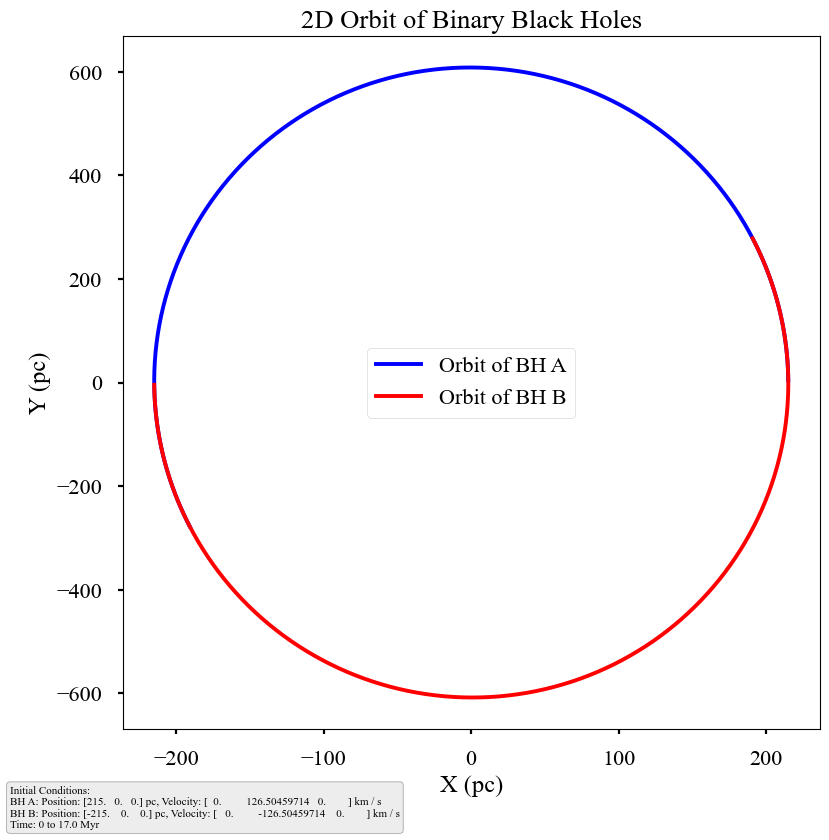

In [45]:
import matplotlib.pyplot as plt

# Create the figure and axis
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111)  # No projection='3d' for 2D plot

# Plot the orbits in 2D (X and Y dimensions)
ax.plot(r1_sol[:, 0], r1_sol[:, 1], label="Orbit of BH A", color="blue")
ax.plot(r2_sol[:, 0], r2_sol[:, 1], label="Orbit of BH B", color="red")

# Set labels and title
ax.set_xlabel('X (pc)')
ax.set_ylabel('Y (pc)')
ax.set_title('2D Orbit of Binary Black Holes')

# Add a legend
ax.legend()

# Add initial conditions as text
initial_conditions_text = (
    f"Initial Conditions:\n"
    f"BH A: Position: {r1_initial}, Velocity: {v1_initial}\n"
    f"BH B: Position: {r2_initial}, Velocity: {v2_inital}\n"
    f"Time: 0 to {T}"
)
fig.text(0.0, 0.0, initial_conditions_text, fontsize=8, bbox=dict(boxstyle="round", facecolor="lightgray", alpha=0.4))

# Show the plot
plt.show()

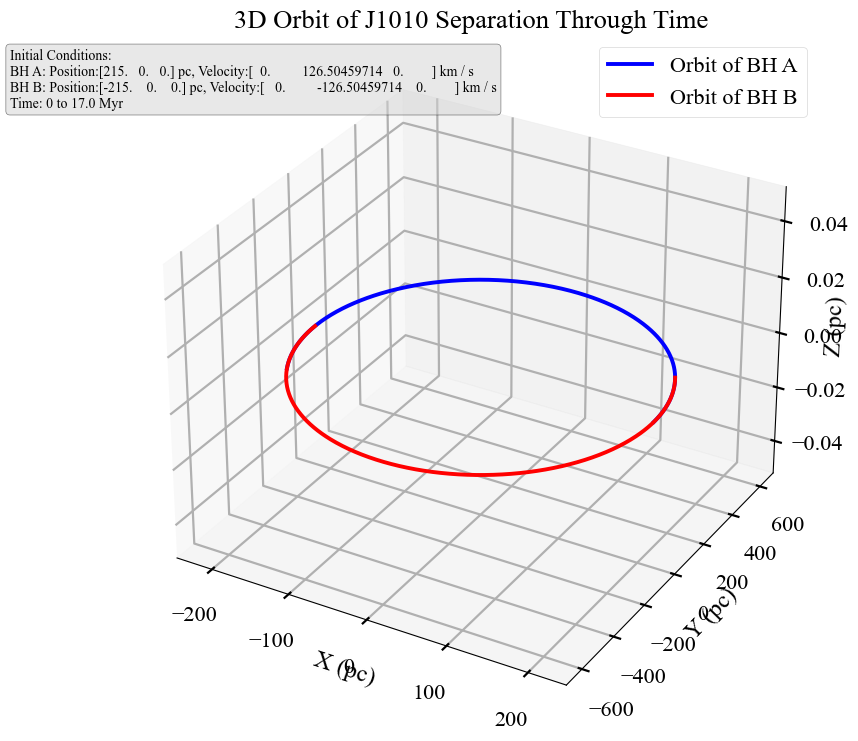

In [46]:

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')


ax.plot(r1_sol[:, 0], r1_sol[:, 1], r1_sol[:, 2], label="Orbit of BH A", color="blue")


ax.plot(r2_sol[:, 0], r2_sol[:, 1], r2_sol[:, 2], label="Orbit of BH B", color="red")


ax.set_xlabel('X (pc)')
ax.set_ylabel('Y (pc)') 
ax.set_zlabel('Z (pc)')
ax.set_title('3D Orbit of J1010 Separation Through Time')


ax.legend()

initial_conditions_text = (
    f"Initial Conditions:\n"
    f"BH A: Position:{r1_initial}, Velocity:{v1_initial}\n"
    f"BH B: Position:{r2_initial}, Velocity:{v2_inital}\n"
    f"Time: 0 to {T}"
)
fig.text(0, 0.8, initial_conditions_text, fontsize=10, bbox=dict(boxstyle="round", facecolor="lightgray", alpha=0.5))

plt.show()

In [47]:
sep = r2_sol[-2] - r1_sol[-2]
sep_magnitude = np.linalg.norm(sep)
print(f'The final separation distance is {sep_magnitude} pc')


The final separation distance is 669.1294315066295 pc


In [48]:
distance1 = np.linalg.norm(u.pc.to(u.m, r1_sol - r2_sol), axis= 1)

p_distance1 = np.min(distance1)
a_distance1 = np.max(distance1)

distance2 = np.linalg.norm(u.pc.to(u.m, r2_sol - r1_sol), axis = 1)

p_distance2 = np.min(distance2)
a_distance2 = np.max(distance2)


# Theoretical data
# Eccentricity and Semi-Major Axis for Black Hole A
r_p1 = p_distance1
r_a1 = a_distance1
eccentricity1 = (r_a1 - r_p1) / (r_a1 + r_p1)




print(f"Eccentricity of the A orbit: {round(eccentricity1, 4)}") #WOOOOOOOH IT IS  0 < EPSILON < 1 !!!!




Eccentricity of the A orbit: 0.4776


/var/folders/rf/799sdl_537nf32dnhw741jq80000gn/T/ipykernel_98577/682720306.py:24: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically expanding.
  ax.set_zlim([min(np.min(r1_sol[:, 2]), np.min(r2_sol[:, 2])), max(np.max(r1_sol[:, 2]), np.max(r2_sol[:, 2]))])


Text(0, 0.8, 'Initial Conditions:\nBH A: Position:[215.   0.   0.] pc, Velocity:[  0.         126.50459714   0.        ] km / s\nBH B: Position:[-215.    0.    0.] pc, Velocity:[   0.         -126.50459714    0.        ] km / s\nTime: 0 to 17.0 Myr')

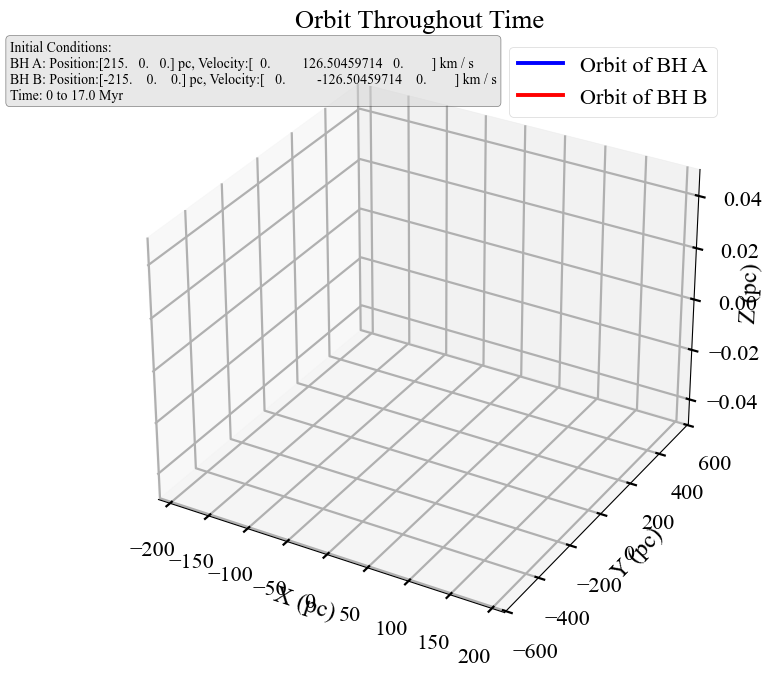

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')


ax.set_xlabel('X (pc)')
ax.set_ylabel('Y (pc)')
ax.set_zlabel('Z (pc)')
ax.set_title('Orbit Throughout Time')


line1, = ax.plot([], [], [], label="Orbit of BH A", color="blue")
line2, = ax.plot([], [], [], label="Orbit of BH B", color="red")
ax.legend()

# Limits for the plot (adjust as needed based on data)
ax.set_xlim([min(np.min(r1_sol[:, 0]), np.min(r2_sol[:, 0])), max(np.max(r1_sol[:, 0]), np.max(r2_sol[:, 0]))])
ax.set_ylim([min(np.min(r1_sol[:, 1]), np.min(r2_sol[:, 1])), max(np.max(r1_sol[:, 1]), np.max(r2_sol[:, 1]))])
ax.set_zlim([min(np.min(r1_sol[:, 2]), np.min(r2_sol[:, 2])), max(np.max(r1_sol[:, 2]), np.max(r2_sol[:, 2]))])


def update(num):

    line1.set_data(r1_sol[:num, 0], r1_sol[:num, 1])
    line1.set_3d_properties(r1_sol[:num, 2])
    
    line2.set_data(r2_sol[:num, 0], r2_sol[:num, 1])
    line2.set_3d_properties(r2_sol[:num, 2])
    
    return line1, line2

initial_conditions_text = (
    f"Initial Conditions:\n"
    f"BH A: Position:{r1_initial}, Velocity:{v1_initial}\n"
    f"BH B: Position:{r2_initial}, Velocity:{v2_inital}\n"
    f"Time: 0 to {T}"
)
fig.text(0, 0.8, initial_conditions_text, fontsize=10, bbox=dict(boxstyle="round", facecolor="lightgray", alpha=0.5))

# ani = FuncAnimation(fig, update, frames=len(r1_sol), interval=50, blit=True)


# plt.show()


# ani.save("J1010#6.mp4", writer="ffmpeg", fps=220)  # Adjust fps as needed

Plot of Velocities

Dynamical Friction Plot

In [50]:
c_values = [0.1, 0.5, 0.75, 1, 0]  
c1list = []
c2list = []
c3list = []
c4list = []
c5list = []
c6list = []


for c in c_values:
    r1_sol = []
    r2_sol = []
    v1_sol = []
    v2_sol = []
    F_D1sol = []
    F_D2sol = []
    F_force1 = []
    F_force2 = []

    G = const.G #change the innate time to years
    m_gal = 1e11 * const.M_sun
    #Masses
    m1=4e8 * const.M_sun #mass of black hole A 
    m2=4e8 * const.M_sun #mass of black hole B
    # Will be adding the Standard Gravitational Parameter
    #r_i has a separation of 430 pc
    sep = 430*u.pc
    r1_initial=[((sep/2.).value),0,0] * u.pc
    r2_initial=[-((sep/2.).value),0,0] * u.pc
    #To arrays
    r1=np.array(r1_initial,dtype="float64") * u.pc
    r2=np.array(r2_initial,dtype="float64") * u.pc

    #Semi-major axis 
    a = (0.5 * (sep))
    print (a)

    #COM
    r_com=(m1*r1+m2*r2)/(m1+m2)

    #orbital veloctiy
    orb_v = (np.sqrt(const.G*(m1+m2)/a)).to(u.km/u.s) #added with Kris' source
    orb_v = orb_v.value

    #V_i
    v1_initial=[-89.135,89.135, 0] *u.km/u.s
    v2_inital=[89.135,-89.135,0] *u.km/u.s #km/s

    #To arrays
    v1=np.array(v1_initial,dtype="float64") *u.km/u.s
    v2=np.array(v2_inital,dtype="float64") *u.km/u.s
    #Find velocity of COM
    v_com=(m1*v1+m2*v2)/(m1+m2)

    r = np.sqrt((r2[0] - r1[0])** 2 + (r2[1] - r1[1])** 2 + (r2[2] - r1[2])** 2)


    for i in range(N):
        dv1bydt=((G*m2*(r2-r1))/r**3).to(u.km / u.s**2) + (a_D1)
        dv2bydt=((-G*m1*(r2-r1))/r**3).to(u.km / u.s**2) + (a_D2) 
        v1 += dv1bydt * delta_t
        v2 += dv2bydt * delta_t

        r1 += v1.to(u.pc / u.s) * delta_t
        r2 += v2.to(u.pc / u.s) * delta_t
        # region Code Snippet 2: DF
        r1_com = r1 - r_com
        r2_com = r2 - r_com

        r1_com = np.sqrt(r1_com[0]**2 + r1_com[1]**2 + r1_com[2]**2) #we have to put the magnitude of the distance from each object from the COM
        r2_com = np.sqrt(r2_com[0]**2 + r2_com[1]**2 + r2_com[2]**2)
    
        o = ((10**(2.2969))*(m_gal/ (10**(11) * const.M_sun))**(0.299)) * (u.km/u.s)
        # region code : Coulomb Logarithm
        x1 = (np.abs(r1_com.to(u.km)) * o**(2)) / (G * m1)
        x2 = (np.abs(r2_com.to(u.km)) * o**(2)) / (G * m2)
        ln_A1 = math.log10(x1.to_value(u.dimensionless_unscaled))
        ln_A2 = math.log10(x2.to_value(u.dimensionless_unscaled))
        # endregion


        F_D1 = 0.428 * ln_A1 * (G * m1**2 / r1_com**2)
        F_D2 = 0.428 * ln_A2 * (G * m2**2 / r2_com**2)




        v_r1 = v1 - v_com
        v_r2 = v2 - v_com


        v_rel_unit1 = v_r1 / np.linalg.norm(v_r1)
        v_rel_unit2 = v_r2 / np.linalg.norm(v_r2)

        F_D1_vector = -1 *(F_D1 * v_rel_unit1)
        F_D2_vector = -1 *(F_D2 * v_rel_unit2)


        F_D1_vector = c * F_D1_vector.to((u.kg * u.m) / (u.s**2))
        F_D2_vector = c * F_D2_vector.to((u.kg * u.m) / (u.s**2))



        # Convert to acceleration
        a_D1 = (F_D1_vector / m1).to(u.km / u.s**2)
        a_D2 = (F_D2_vector / m2).to(u.km / u.s**2)



        # Append results to lists (if needed)
        F_force1.append(F_D1_vector.to(u.kg * u.m / u.s**2))
        F_force2.append(F_D2_vector.to(u.kg * u.m / u.s**2))
        F_D1sol.append([a_D1[0].value, a_D1[1].value, a_D1[2].value])
        F_D2sol.append([a_D2[0].value, a_D2[1].value, a_D2[2].value])

        r1_sol.append(r1.copy())
        r2_sol.append(r2.copy())
        v1_sol.append(v1.copy())
        v2_sol.append(v2.copy())


    F_D1sol = np.array(F_D1sol)
    F_D2sol = np.array(F_D2sol)
    v1_sol = np.array(v1_sol)
    v2_sol = np.array(v2_sol)
    r1_sol = np.array(r1_sol)
    r2_sol = np.array(r2_sol)



    mag_fd1 = np.sqrt(F_D1sol[:, 0]**2 + F_D1sol[:, 1]**2 + F_D1sol[:, 2]**2)
    mag_fd2 = np.sqrt(F_D2sol[:, 0]**2 + F_D2sol[:, 1]**2 + F_D2sol[:, 2]**2)
    sep_mag = np.linalg.norm(r2_sol - r1_sol, axis=1) * u.pc

    pos_mag = np.linalg.norm(r1_sol, axis=1) * (u.pc)
    vel_mag = np.linalg.norm(v1_sol, axis=1) * (u.km / u.s)
    ang_mom = (m1 * (pos_mag * vel_mag)).to(u.kg * u.km**2 / u.s) 

    c1list.append(mag_fd1)
    c2list.append(sep_mag)
    c3list.append(pos_mag)
    c4list.append(vel_mag)
    c5list.append(ang_mom)




215.0 pc
215.0 pc
215.0 pc
215.0 pc
215.0 pc


/var/folders/rf/799sdl_537nf32dnhw741jq80000gn/T/ipykernel_98577/4068103499.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  [a.legend(fontsize = 10) for a in axs.ravel()]


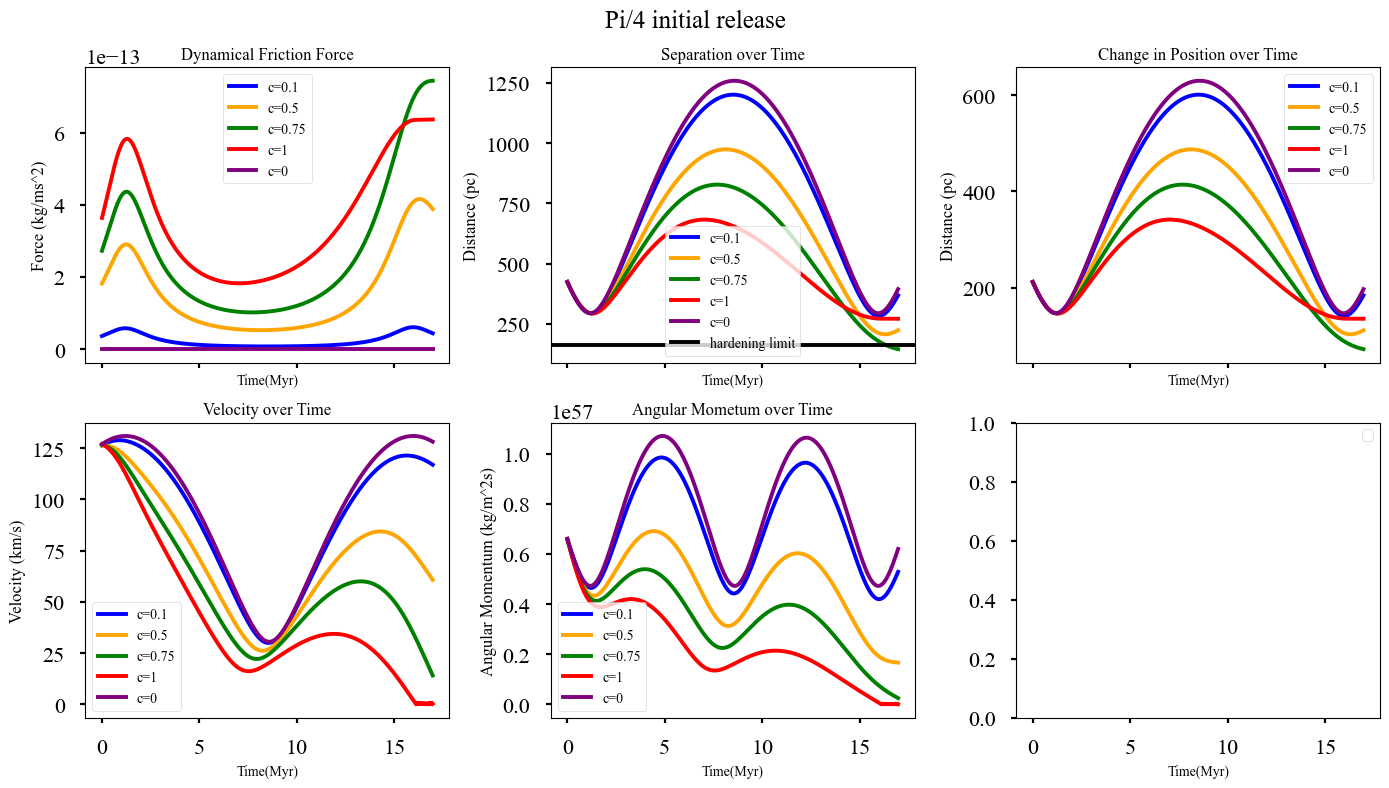

In [51]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8), sharex=True)



axs[0,0].plot(time_values, c1list[0], label="c=0.1", color='blue')
axs[0,0].plot(time_values, c1list[1], label="c=0.5", color='orange')
axs[0,0].plot(time_values, c1list[2], label="c=0.75", color = 'green')
axs[0,0].plot(time_values, c1list[3], label="c=1", color = 'red')
axs[0,0].plot(time_values, c1list[4], label="c=0", color = 'purple')

axs[0,0].set_ylabel("Force (kg/ms^2)", fontsize=12)


axs[0,1].plot(time_values, c2list[0], label="c=0.1", color='blue')
axs[0,1].plot(time_values, c2list[1], label="c=0.5", color='orange')
axs[0,1].plot(time_values, c2list[2], label="c=0.75", color = 'green')
axs[0,1].plot(time_values, c2list[3], label="c=1", color = 'red')
axs[0,1].plot(time_values, c2list[4], label="c=0", color = 'purple')
axs[0,1].axhline(dynhard_rad.value * 2, color='black', label="hardening limit")
axs[0,1].set_ylabel("Distance (pc)", fontsize=12)


axs[0,2].plot(time_values, c3list[0], label="c=0.1", color='blue')
axs[0,2].plot(time_values, c3list[1], label="c=0.5", color='orange')
axs[0,2].plot(time_values, c3list[2], label="c=0.75", color = 'green')
axs[0,2].plot(time_values, c3list[3], label="c=1", color = 'red')
axs[0,2].plot(time_values, c3list[4], label="c=0", color = 'purple')
axs[0,2].set_ylabel("Distance (pc)", fontsize=12)

axs[1,0].plot(time_values, c4list[0], label="c=0.1", color='blue')
axs[1,0].plot(time_values, c4list[1], label="c=0.5", color='orange')
axs[1,0].plot(time_values, c4list[2], label="c=0.75", color = 'green')
axs[1,0].plot(time_values, c4list[3], label="c=1", color = 'red')
axs[1,0].plot(time_values, c4list[4], label="c=0", color = 'purple')
axs[1,0].set_ylabel("Velocity (km/s)", fontsize=12)


axs[1,1].plot(time_values, c5list[0], label="c=0.1", color='blue')
axs[1,1].plot(time_values, c5list[1], label="c=0.5", color='orange')
axs[1,1].plot(time_values, c5list[2], label="c=0.75", color = 'green')
axs[1,1].plot(time_values, c5list[3], label="c=1", color = 'red')
axs[1,1].plot(time_values, c5list[4], label="c=0", color = 'purple')
axs[1,1].set_ylabel("Angular Momentum (kg/m^2s)", fontsize=12)


axs[0,0].set_title("Dynamical Friction Force", fontsize=12)
axs[0,1].set_title("Separation over Time", fontsize = 12)
axs[0,2].set_title("Change in Position over Time", fontsize = 12)
axs[1,0].set_title("Velocity over Time", fontsize = 12)
axs[1,1].set_title("Angular Mometum over Time", fontsize = 12)



[a.legend(fontsize = 10) for a in axs.ravel()]
[a.set_xlabel(xlabel = "Time(Myr)", fontsize = 10) for a in axs.ravel()]

fig.suptitle("Pi/4 initial release", fontsize = 18)


# axs[0].set_xlabel("Time (Myr)")
# axs[0].set_ylabel("Force Magnitude (km/s²)")
# axs[0].legend()

# axs[1].set_title("Dynamical Friction - Body 2")
# axs[1].set_xlabel("Time (Myr)")
# axs[1].set_ylabel("Force Magnitude (km/s²)")
# axs[1].legend()

plt.tight_layout()
plt.show()

In [52]:
c_values = [0.1, 0.5, 0.75, 1, 0]  
c1list = []
c2list = []
c3list = []
c4list = []
c5list = []
c6list = []


for c in c_values:
    r1_sol = []
    r2_sol = []
    v1_sol = []
    v2_sol = []
    F_D1sol = []
    F_D2sol = []
    F_force1 = []
    F_force2 = []

    G = const.G #change the innate time to years
    m_gal = 1e11 * const.M_sun
    #Masses
    m1=4e8 * const.M_sun #mass of black hole A 
    m2=4e8 * const.M_sun #mass of black hole B
    # Will be adding the Standard Gravitational Parameter
    #r_i has a separation of 430 pc
    sep = 430*u.pc
    r1_initial=[((sep/2.).value),0,0] * u.pc
    r2_initial=[-((sep/2.).value),0,0] * u.pc
    #To arrays
    r1=np.array(r1_initial,dtype="float64") * u.pc
    r2=np.array(r2_initial,dtype="float64") * u.pc

    #Semi-major axis 
    a = (0.5 * (sep))
    print (a)

    #COM
    r_com=(m1*r1+m2*r2)/(m1+m2)

    #orbital veloctiy
    orb_v = (np.sqrt(const.G*(m1+m2)/a)).to(u.km/u.s) #added with Kris' source
    orb_v = orb_v.value

    #V_i
    v1_initial=[0,orb_v, 0] *u.km/u.s
    v2_inital=[0,-orb_v,0] *u.km/u.s #km/s

    #To arrays
    v1=np.array(v1_initial,dtype="float64") *u.km/u.s
    v2=np.array(v2_inital,dtype="float64") *u.km/u.s
    #Find velocity of COM
    v_com=(m1*v1+m2*v2)/(m1+m2)

    r = np.sqrt((r2[0] - r1[0])** 2 + (r2[1] - r1[1])** 2 + (r2[2] - r1[2])** 2)


    for i in range(N):
        dv1bydt=((G*m2*(r2-r1))/r**3).to(u.km / u.s**2) + (a_D1)
        dv2bydt=((-G*m1*(r2-r1))/r**3).to(u.km / u.s**2) + (a_D2) 
        v1 += dv1bydt * delta_t
        v2 += dv2bydt * delta_t

        r1 += v1.to(u.pc / u.s) * delta_t
        r2 += v2.to(u.pc / u.s) * delta_t
        # region Code Snippet 2: DF
        r1_com = r1 - r_com
        r2_com = r2 - r_com

        r1_com = np.sqrt(r1_com[0]**2 + r1_com[1]**2 + r1_com[2]**2) #we have to put the magnitude of the distance from each object from the COM
        r2_com = np.sqrt(r2_com[0]**2 + r2_com[1]**2 + r2_com[2]**2)
    
        o = ((10**(2.2969))*(m_gal/ (10**(11) * const.M_sun))**(0.299)) * (u.km/u.s)
        # region code : Coulomb Logarithm
        x1 = (np.abs(r1_com.to(u.km)) * o**(2)) / (G * m1)
        x2 = (np.abs(r2_com.to(u.km)) * o**(2)) / (G * m2)
        ln_A1 = math.log10(x1.to_value(u.dimensionless_unscaled))
        ln_A2 = math.log10(x2.to_value(u.dimensionless_unscaled))
        # endregion


        F_D1 = 0.428 * ln_A1 * (G * m1**2 / r1_com**2)
        F_D2 = 0.428 * ln_A2 * (G * m2**2 / r2_com**2)




        v_r1 = v1 - v_com
        v_r2 = v2 - v_com


        v_rel_unit1 = v_r1 / np.linalg.norm(v_r1)
        v_rel_unit2 = v_r2 / np.linalg.norm(v_r2)

        F_D1_vector = -1 *(F_D1 * v_rel_unit1)
        F_D2_vector = -1 *(F_D2 * v_rel_unit2)


        F_D1_vector = c * F_D1_vector.to((u.kg * u.m) / (u.s**2))
        F_D2_vector = c * F_D2_vector.to((u.kg * u.m) / (u.s**2))



        # Convert to acceleration
        a_D1 = (F_D1_vector / m1).to(u.km / u.s**2)
        a_D2 = (F_D2_vector / m2).to(u.km / u.s**2)



        # Append results to lists (if needed)
        F_force1.append(F_D1_vector.to(u.kg * u.m / u.s**2))
        F_force2.append(F_D2_vector.to(u.kg * u.m / u.s**2))
        F_D1sol.append([a_D1[0].value, a_D1[1].value, a_D1[2].value])
        F_D2sol.append([a_D2[0].value, a_D2[1].value, a_D2[2].value])

        r1_sol.append(r1.copy())
        r2_sol.append(r2.copy())
        v1_sol.append(v1.copy())
        v2_sol.append(v2.copy())


    F_D1sol = np.array(F_D1sol)
    F_D2sol = np.array(F_D2sol)
    v1_sol = np.array(v1_sol)
    v2_sol = np.array(v2_sol)
    r1_sol = np.array(r1_sol)
    r2_sol = np.array(r2_sol)



    mag_fd1 = np.sqrt(F_D1sol[:, 0]**2 + F_D1sol[:, 1]**2 + F_D1sol[:, 2]**2)
    mag_fd2 = np.sqrt(F_D2sol[:, 0]**2 + F_D2sol[:, 1]**2 + F_D2sol[:, 2]**2)
    sep_mag = np.linalg.norm(r2_sol - r1_sol, axis=1) * u.pc

    pos_mag = np.linalg.norm(r1_sol, axis=1) * (u.pc)
    vel_mag = np.linalg.norm(v1_sol, axis=1) * (u.km / u.s)
    ang_mom = (m1 * (pos_mag * vel_mag)).to(u.kg * u.km**2 / u.s) 

    c1list.append(mag_fd1)
    c2list.append(sep_mag)
    c3list.append(pos_mag)
    c4list.append(vel_mag)
    c5list.append(ang_mom)




215.0 pc
215.0 pc
215.0 pc
215.0 pc
215.0 pc


/var/folders/rf/799sdl_537nf32dnhw741jq80000gn/T/ipykernel_98577/1089286933.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  [a.legend(fontsize = 10) for a in axs.ravel()]


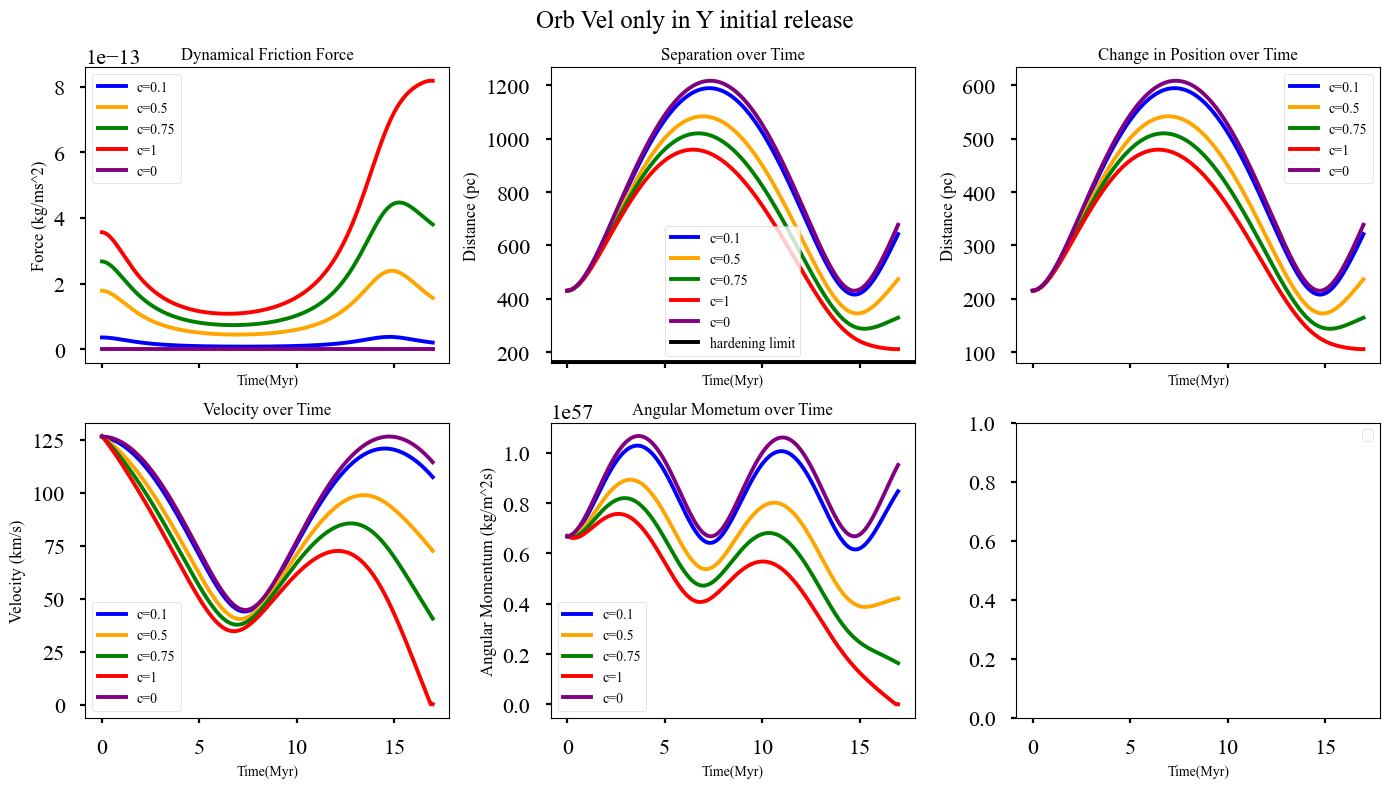

In [53]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8), sharex=True)



axs[0,0].plot(time_values, c1list[0], label="c=0.1", color='blue')
axs[0,0].plot(time_values, c1list[1], label="c=0.5", color='orange')
axs[0,0].plot(time_values, c1list[2], label="c=0.75", color = 'green')
axs[0,0].plot(time_values, c1list[3], label="c=1", color = 'red')
axs[0,0].plot(time_values, c1list[4], label="c=0", color = 'purple')

axs[0,0].set_ylabel("Force (kg/ms^2)", fontsize=12)


axs[0,1].plot(time_values, c2list[0], label="c=0.1", color='blue')
axs[0,1].plot(time_values, c2list[1], label="c=0.5", color='orange')
axs[0,1].plot(time_values, c2list[2], label="c=0.75", color = 'green')
axs[0,1].plot(time_values, c2list[3], label="c=1", color = 'red')
axs[0,1].plot(time_values, c2list[4], label="c=0", color = 'purple')
axs[0,1].axhline(dynhard_rad.value * 2, color='black', label="hardening limit")
axs[0,1].set_ylabel("Distance (pc)", fontsize=12)


axs[0,2].plot(time_values, c3list[0], label="c=0.1", color='blue')
axs[0,2].plot(time_values, c3list[1], label="c=0.5", color='orange')
axs[0,2].plot(time_values, c3list[2], label="c=0.75", color = 'green')
axs[0,2].plot(time_values, c3list[3], label="c=1", color = 'red')
axs[0,2].plot(time_values, c3list[4], label="c=0", color = 'purple')
axs[0,2].set_ylabel("Distance (pc)", fontsize=12)

axs[1,0].plot(time_values, c4list[0], label="c=0.1", color='blue')
axs[1,0].plot(time_values, c4list[1], label="c=0.5", color='orange')
axs[1,0].plot(time_values, c4list[2], label="c=0.75", color = 'green')
axs[1,0].plot(time_values, c4list[3], label="c=1", color = 'red')
axs[1,0].plot(time_values, c4list[4], label="c=0", color = 'purple')
axs[1,0].set_ylabel("Velocity (km/s)", fontsize=12)


axs[1,1].plot(time_values, c5list[0], label="c=0.1", color='blue')
axs[1,1].plot(time_values, c5list[1], label="c=0.5", color='orange')
axs[1,1].plot(time_values, c5list[2], label="c=0.75", color = 'green')
axs[1,1].plot(time_values, c5list[3], label="c=1", color = 'red')
axs[1,1].plot(time_values, c5list[4], label="c=0", color = 'purple')
axs[1,1].set_ylabel("Angular Momentum (kg/m^2s)", fontsize=12)


axs[0,0].set_title("Dynamical Friction Force", fontsize=12)
axs[0,1].set_title("Separation over Time", fontsize = 12)
axs[0,2].set_title("Change in Position over Time", fontsize = 12)
axs[1,0].set_title("Velocity over Time", fontsize = 12)
axs[1,1].set_title("Angular Mometum over Time", fontsize = 12)



[a.legend(fontsize = 10) for a in axs.ravel()]
[a.set_xlabel(xlabel = "Time(Myr)", fontsize = 10) for a in axs.ravel()]

fig.suptitle("Orb Vel only in Y initial release", fontsize = 18)


# axs[0].set_xlabel("Time (Myr)")
# axs[0].set_ylabel("Force Magnitude (km/s²)")
# axs[0].legend()

# axs[1].set_title("Dynamical Friction - Body 2")
# axs[1].set_xlabel("Time (Myr)")
# axs[1].set_ylabel("Force Magnitude (km/s²)")
# axs[1].legend()

plt.tight_layout()
plt.show()